In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [2]:
variables = [
    'essentiality',
    'expression',
    'long_insert_size',
    'homologue_existence',
    'involvement_in_disease',
    'cancer',
]

color_discrete_map = {
    "ORF": "#009e73",
    "CRISPR": "#d55e00",
}

In [3]:
fisher_df = pd.DataFrame()

for var in variables:
    df = pd.read_csv(
        f"output/{var}.csv",
        usecols=[
            "modality",
            "odds_ratio",
            "pvalue",
            "confidence_interval_low",
            "confidence_interval_high",
        ],
    )
    df["variable"] = var
    fisher_df = pd.concat([fisher_df, df], ignore_index=True)

fisher_df.head()

,modality,odds_ratio,pvalue,confidence_interval_low,confidence_interval_high,variable
0,ORF,0.804303,1.463946e-04,0.718088,0.900990,essentiality
1,CRISPR,6.201463,5.051865e-55,4.636967,8.451643,essentiality
2,ORF,1.041577,3.227504e-01,0.961519,1.128443,expression
3,CRISPR,2.110171,2.199729e-35,1.863666,2.392546,expression
4,ORF,0.998224,1.000000e+00,0.861772,1.157059,long_insert_size


In [4]:
offset_df = fisher_df[['variable', 'modality', 'odds_ratio']].sort_values(by=['variable', 'odds_ratio']).reset_index(drop=True)
offset_df

offset_df["offset"] = 0

for i, row in offset_df.iterrows():
    if i % 2 == 0:  # Even-indexed odds ratios
        offset_df.loc[i, "offset"] = -1  # Offset to the left
    else:  # Odd-indexed odds ratios
        offset_df.loc[i, "offset"] = 1  # Offset to the right

fisher_df = fisher_df.merge(offset_df, on=["variable", "modality", "odds_ratio"], how="left")
fisher_df.head()

,modality,odds_ratio,pvalue,confidence_interval_low,confidence_interval_high,variable,offset
0,ORF,0.804303,1.463946e-04,0.718088,0.900990,essentiality,-1
1,CRISPR,6.201463,5.051865e-55,4.636967,8.451643,essentiality,1
2,ORF,1.041577,3.227504e-01,0.961519,1.128443,expression,-1
3,CRISPR,2.110171,2.199729e-35,1.863666,2.392546,expression,1
4,ORF,0.998224,1.000000e+00,0.861772,1.157059,long_insert_size,-1


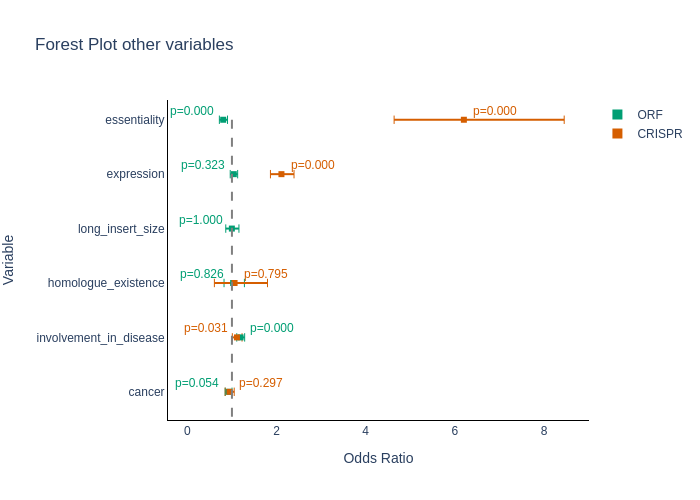

In [5]:
# Create Figure
fig = go.Figure()

# Add error bars (confidence intervals)
for i, row in fisher_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row["confidence_interval_low"], row["confidence_interval_high"]],
            y=[row["variable"], row["variable"]],
            mode="lines",
            line=dict(color=color_discrete_map[row["modality"]]),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[row["confidence_interval_low"], row["confidence_interval_high"]],
            y=[row["variable"], row["variable"]],
            mode="markers",
            marker=dict(
                color=color_discrete_map[row["modality"]], symbol="line-ns-open"
            ),
            showlegend=False,
        )
    )

# Add markers for odds ratios
fig.add_trace(
    go.Scatter(
        x=fisher_df["odds_ratio"],
        y=fisher_df["variable"],
        mode="markers",
        marker=dict(
            color=fisher_df["modality"].map(color_discrete_map), symbol="square"
        ),  # Square markers
        showlegend=False,
    )
)

# Add p-value annotations
for i, row in fisher_df.iterrows():
    # Calculate x-coordinate for annotation (adjust offset as needed)
    x_offset = 0.7 * row["offset"]
    x_annotation = row["odds_ratio"] + x_offset

    fig.add_annotation(
        x=x_annotation,
        y=row["variable"],
        text=f'p={row["pvalue"]:.3f}',
        showarrow=False,
        yanchor="bottom",
        font=dict(size=12, color=color_discrete_map[row['modality']]),  # Adjust font size as needed
    )

for dataset, color in color_discrete_map.items():
    custom_legend = go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=10, color=color, symbol='square'), 
        name=dataset,
        showlegend=True
    )
    fig.add_trace(custom_legend)

# Customize Layout
fig.update_layout(
    title="Forest Plot other variables",
    xaxis=dict(title="Odds Ratio", linecolor="black"),
    yaxis=dict(title="Variable", linecolor="black", autorange="reversed"),
    showlegend=True,
    shapes=[
        dict(
            type="line",
            x0=1,
            x1=1,
            y0=0,
            y1=len(fisher_df)/2,
            line=dict(color="grey", dash="dash"),
        )
    ],
    plot_bgcolor="rgba(0,0,0,0)",
)

fig.show("png")
fig.write_image("figures/forest-plot-other-variables.png", height=480, width=640, scale=2)
fig.write_image("figures/forest-plot-other-variables.svg", height=480, width=640, scale=2)

In [6]:
# Protein class

fisher_df = pd.read_csv(
    "output/protein_class.csv",
    usecols=[
        "modality",
        "odds_ratio",
        "pvalue",
        "confidence_interval_low",
        "confidence_interval_high",
        "protein_class"
    ],
)

fisher_df.head()

,protein_class,modality,odds_ratio,pvalue,confidence_interval_low,confidence_interval_high
0,Enzymes,ORF,0.994910,0.925051,0.906340,1.092229
1,Transporters,ORF,0.914428,0.461767,0.715439,1.171435
2,G-protein coupled receptors,ORF,1.116559,0.343367,0.890759,1.403790
3,Transcription factors,ORF,0.963858,0.626459,0.830598,1.119409
4,Immunoglobulin genes,ORF,0.761633,0.472756,0.357226,1.640526


In [7]:
offset_df = fisher_df[['protein_class', 'modality', 'odds_ratio']].sort_values(by=['protein_class', 'odds_ratio']).reset_index(drop=True)
offset_df

offset_df["offset"] = 0

for i, row in offset_df.iterrows():
    if i % 2 == 0:  # Even-indexed odds ratios
        offset_df.loc[i, "offset"] = -1  # Offset to the left
    else:  # Odd-indexed odds ratios
        offset_df.loc[i, "offset"] = 1  # Offset to the right

fisher_df = fisher_df.merge(offset_df, on=["protein_class", "modality", "odds_ratio"], how="left")
fisher_df.head()

,protein_class,modality,odds_ratio,pvalue,confidence_interval_low,confidence_interval_high,offset
0,Enzymes,ORF,0.994910,0.925051,0.906340,1.092229,-1
1,Transporters,ORF,0.914428,0.461767,0.715439,1.171435,-1
2,G-protein coupled receptors,ORF,1.116559,0.343367,0.890759,1.403790,1
3,Transcription factors,ORF,0.963858,0.626459,0.830598,1.119409,-1
4,Immunoglobulin genes,ORF,0.761633,0.472756,0.357226,1.640526,-1


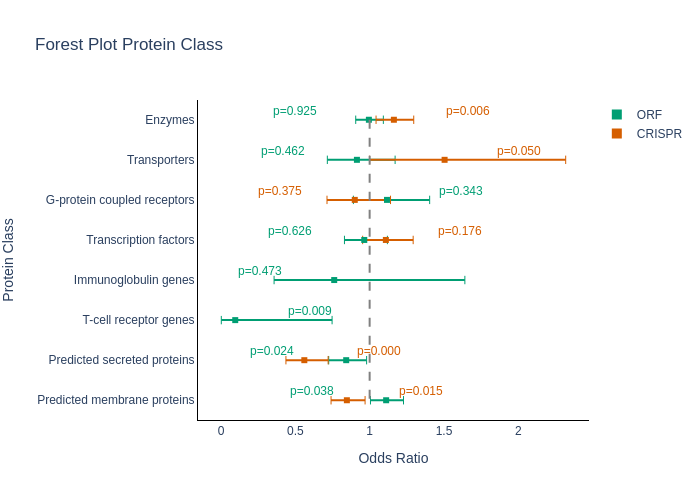

In [8]:
# Create Figure
fig = go.Figure()

# Add error bars (confidence intervals)
for i, row in fisher_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row["confidence_interval_low"], row["confidence_interval_high"]],
            y=[row["protein_class"], row["protein_class"]],
            mode="lines",
            line=dict(color=color_discrete_map[row["modality"]]),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[row["confidence_interval_low"], row["confidence_interval_high"]],
            y=[row["protein_class"], row["protein_class"]],
            mode="markers",
            marker=dict(
                color=color_discrete_map[row["modality"]], symbol="line-ns-open"
            ),
            showlegend=False,
        )
    )

# Add markers for odds ratios
fig.add_trace(
    go.Scatter(
        x=fisher_df["odds_ratio"],
        y=fisher_df["protein_class"],
        mode="markers",
        marker=dict(
            color=fisher_df["modality"].map(color_discrete_map), symbol="square"
        ),  # Square markers
        showlegend=False,
    )
)

# Add p-value annotations
for i, row in fisher_df.iterrows():
    # Calculate x-coordinate for annotation (adjust offset as needed)
    x_offset = 0.5 * row["offset"]
    x_annotation = row["odds_ratio"] + x_offset

    fig.add_annotation(
        x=x_annotation,
        y=row["protein_class"],
        text=f'p={row["pvalue"]:.3f}',
        showarrow=False,
        yanchor="bottom",
        font=dict(size=12, color=color_discrete_map[row['modality']]),  # Adjust font size as needed
    )

for dataset, color in color_discrete_map.items():
    custom_legend = go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=10, color=color, symbol='square'), 
        name=dataset,
        showlegend=True
    )
    fig.add_trace(custom_legend)

# Customize Layout
fig.update_layout(
    title="Forest Plot Protein Class",
    xaxis=dict(title="Odds Ratio", linecolor="black"),
    yaxis=dict(title="Protein Class", linecolor="black", autorange="reversed"),
    showlegend=True,
    shapes=[
        dict(
            type="line",
            x0=1,
            x1=1,
            y0=0,
            y1=len(fisher_df)/2,
            line=dict(color="grey", dash="dash"),
        )
    ],
    plot_bgcolor="rgba(0,0,0,0)",
)

fig.show("png")
fig.write_image("figures/forest-plot-protein-class.png", height=480, width=640, scale=2)
fig.write_image("figures/forest-plot-protein-class.svg", height=480, width=640, scale=2)